In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
import random
import time
import csv
import math
import bisect
import random
from collections import Counter
from collections.abc import Sequence

In [2]:
def exact_netx(graph):
  start = time.time()
  t = sum(nx.triangles(graph).values())/3
  end = time.time()
  return {"triangles": t, "time": end - start}

In [3]:
def exact_trace(graph):
  start = time.time()
  adj_matrix = nx.adjacency_matrix(graph, dtype = np.float64)
  adj_matrix_cubed = adj_matrix @ adj_matrix @ adj_matrix
  print(adj_matrix_cubed.trace())
  t = adj_matrix_cubed.trace()/6
  end = time.time()
  return {"triangles": t, "time": end - start}

In [4]:
def uniform_sampling(graph, sample_size):
  start = time.time()
  nodes = list(graph.nodes)
  n = len(nodes)
  node_sample = random.sample(nodes, sample_size)
  sample_t = 0
  for node in node_sample:
    sample_t += nx.triangles(graph, node)
  sample_t /= 3
  t = sample_t*n/sample_size
  end = time.time()
  return {"triangles": t, "time": end - start}

In [5]:
def random_sampling_with_degrees(graph, sample_size):
  start = time.time()
  nodes = []
  degrees = []
  sum_of_degrees=0
  for node in graph:
    nodes.append(node)
    degree=graph.degree(node)
    degrees.append(degree)
    sum_of_degrees+=degree
  node_sample = random.choices(nodes, weights = degrees, k = sample_size)
  sample_t = 0
  for node in node_sample:
    sample_t += nx.triangles(graph, node)/graph.degree(node)
  t = (sample_t*sum_of_degrees/3)*(1/sample_size)
  end = time.time()
  return {"triangles": t, "time": end - start}

 

In [6]:
def random_sampling_without_replacement(graph, sample_size):
  start = time.time()
  nodes = []
  degrees = []
  sum_of_degrees=0
  for node in graph:
    nodes.append(node)
    degree=graph.degree(node)
    degrees.append(degree)
    sum_of_degrees+=degree
  node_sample = weighted_sample(nodes, weights = degrees, k = sample_size)
  sample_t = 0
  for node in node_sample:
    sample_t += nx.triangles(graph, node)/graph.degree(node)
  t = (sample_t*sum_of_degrees/3)*(1/sample_size)
  end = time.time()
  return {"triangles": t, "time": end - start}

def weighted_sample(population, weights, k):
    return random.sample(WeightedPopulation(population, weights), k)

class WeightedPopulation(Sequence):
    def __init__(self, population, weights):
        assert len(population) == len(weights) > 0
        self.population = population
        self.cumweights = []
        cumsum = 0 # compute cumulative weight
        for w in weights:
            cumsum += w   
            self.cumweights.append(cumsum)  
    def __len__(self):
        return self.cumweights[-1]
    def __getitem__(self, i):
        if not 0 <= i < len(self):
            raise IndexError(i)
        return self.population[bisect.bisect(self.cumweights, i)]
  

In [ ]:
#polynomial degree sampling
def random_sampling_with_degrees(graph, sample_size):
  start = time.time()
  nodes = []
  degrees = []
  sum_of_degrees=0
  for node in graph:
    nodes.append(node)
    degree=graph.degree(node)
    degrees.append(degree)
    sum_of_degrees+=degree
  node_sample = random.choices(nodes, weights = degrees, k = sample_size)
  sample_t = 0
  for node in node_sample:
    sample_t += nx.triangles(graph, node)/graph.degree(node)
  t = (sample_t*sum_of_degrees/3)*(1/sample_size)
  end = time.time()
  return {"triangles": t, "time": end - start}

In [7]:
def hutch(graph, trials):
    start = time.time()
    adj = nx.adjacency_matrix(graph, dtype = np.float64)
    adj = adj.toarray()
    d = adj.shape[0]
    total = 0
    for _ in range(trials):
        v = np.random.choice([-1,1], d)
        tr = np.transpose(v) @ (adj @ (adj @ (adj @ v)))
        total += tr
    total/=trials
    end = time.time()
    return {"triangles" : total/6, "time": end-start, "trials": trials}

In [8]:
def hutchplusplus(graph, queries):
    start = time.time()
    A = nx.adjacency_matrix(graph, dtype = np.float64)
    d = A.shape[0]
    source = [1, -1]
    S = np.random.choice(source, (d, queries//3))
    G = np.random.choice(source, (d, queries//3))
    def mult(x):
        return A @ (A @ (A @ x))
    Q, R = np.linalg.qr(mult(S))
    term_1 = np.trace(Q.T @ mult(Q))
    term_prod = G - Q @ (Q.T @ G)
    term_2 = 3/queries*np.trace(term_prod.T @ mult(term_prod))
    t = term_1/6 + term_2/6
    end = time.time()
    return {"triangles": t, "time": end - start}

In [9]:
# def lanczos(A, m):
#     n = A.shape[0]
#     v = [np.random.rand(n)]
#     w_prime = [A @ v[0]]
#     alpha = [w_prime[0] * v[0]]
#     beta = []
#     w = [w_prime[0] - alpha[0] @ v[0]]
#     for j in range(2, m + 1):
#         beta_j = np.linalg.norm(w[-1])
#         beta.push(beta_j)
#         if beta_j != 0:
#             v_j = w[-1]/beta_j
#         else:
#             v_j = #TODO
#         v.push(v_j)
#         w_prime.push(A @ v[-1])
#         alpha.push(w_prime[-1]*v[-1])


In [10]:
# def eigenTriangle(graph, sample_size, tol):
#   adj_matrix = nx.adjacency_matrix(graph, dtype = np.float64)
#   nodes = list(graph.nodes)
#   n = len(nodes)
#   node_sample = random.sample(nodes, sample_size)
#   for node in node_sample:
#     lambda_1 = lanczos(A, 1)
#     eigen = lambda_1
#     i = 2

In [11]:
fb = nx.read_edgelist('facebook_combined.txt', create_using = nx.Graph(), nodetype = int)
nnodes_fb = fb.number_of_nodes()
ntriangles = nx.triangles(fb, 0)
exact_networkx_metrics = exact_netx(fb)
print(exact_networkx_metrics)
# hutch_count = hutch(fb)
# print(hutch_count)
# exact_trace_metrics = exact_trace(fb)
# print(exact_trace_metrics)

# uniform_sampling_metrics = uniform_sampling(fb, 404)
# print(uniform_sampling_metrics)
# rel_error = abs(ntriangles - uniform_sampling_metrics['triangles'])/ntriangles
# print(rel_error)

{'triangles': 1612010.0, 'time': 0.6746501922607422}


In [12]:
def repeat_weighted(n):
    for i in range(n):
        weighted_sampling_metrics = random_sampling_with_degrees(fb, 404)
        print(weighted_sampling_metrics)
        rel_error = abs(ntriangles - weighted_sampling_metrics['triangles'])/ntriangles
        print(rel_error)

In [16]:
# Sampling Testing Function
def testing_graph_methods_sampling(graph, accuracies, times,algo):
 
    exact_netx_result = exact_netx(graph)
    exact_triangles = exact_netx_result['triangles']
    print(f"Exact NetworkX Triangles: {exact_triangles}, Time: {exact_netx_result['time']}s")
 
    total_nodes = len(graph.nodes())
    sample_sizes = [int(total_nodes * percentage / 100) for percentage in range(5,55,5) ]
    algo_name=algo.__name__
    method_accuracies=[0 for sample_size in range(0,len(sample_sizes)+1) ]
    method_times=[0 for percentage in range(0,len(sample_sizes)+1)]
 
# create for loop for trials and another for loop for sample size according to sampling; between 5% and 50% in increments of 5% f the sample size given.
    # evaluate each method with respective names according to the methods being used
    for trial in range(0,10):
            # Run 10 trials for the current method and sample size
            iteration=0
            for sample_size in sample_sizes:
                print(f"Trial {trial} for {algo_name} with Sample Size: {sample_size}")
                result = algo(graph, sample_size)
                rel_error = abs(exact_triangles - result['triangles']) / exact_triangles
                method_accuracies[iteration]+=rel_error
                method_times[iteration]+=result['time']
                iteration+=1
    #Go over each sample size and average their accuracies and times
    for iteration in range(0,10):   
      avg_time = method_times[iteration] /10
      avg_accuracy=method_accuracies[iteration]/10
      accuracies.append((algo_name, sample_sizes[iteration], avg_accuracy))
      times.append((algo_name, sample_sizes[iteration], avg_time))
 
accuracies = []
times = []
 
fb_graph = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
 
testing_graph_methods_sampling(fb_graph, accuracies, times,random_sampling_without_replacement)
 
print("Accuracies:", accuracies)
print("Times:", times)
with open('output_accuracy.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(accuracies)
with open('output_time.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(times)

Exact NetworkX Triangles: 1612010.0, Time: 1.0205802917480469s
Trial 0 for random_sampling_without_replacement with Sample Size: 201
Trial 0 for random_sampling_without_replacement with Sample Size: 403
Trial 0 for random_sampling_without_replacement with Sample Size: 605
Trial 0 for random_sampling_without_replacement with Sample Size: 807


KeyboardInterrupt: 

In [ ]:
#Regular Testing Function
def testing_graph_methods_regular(graph, accuracies, times,algo):
 
    exact_netx_result = exact_netx(graph)
    exact_triangles = exact_netx_result['triangles']
    print(f"Exact NetworkX Triangles: {exact_triangles}, Time: {exact_netx_result['time']}s")
 
    total_nodes = len(graph.nodes())
    algo_name=algo.__name__
 
# create for loop for trials
    method_accuracies = 0
    method_times = 0
    for trial in range(1, 11):
        print(f"Trial {trial} for {algo_name} ")
        result = algo(graph)
        rel_error = abs(exact_triangles - result['triangles']) / exact_triangles
        method_accuracies+=rel_error
        method_times+=result['time']

    avg_time = method_times /10
    avg_accuracy=method_accuracies/10
    accuracies.append((algo_name, avg_accuracy))
    times.append((algo_name, avg_time))
    print(f"{algo_name} average accuracy: {avg_accuracy}, average time: {avg_time}s")
 
 
accuracies = []
times = []
 
fb_graph = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
 
testing_graph_methods_regular(fb_graph, accuracies, times,exact_trace)
 
print("Accuracies:", accuracies)
print("Times:", times)
with open('output.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(accuracies)
    writer.writerow("\n")
    writer.writerows(times)
    writer.writerow("\n")



Exact NetworkX Triangles: 1612010.0, Time: 0.46753501892089844s
Trial 1 for exact_trace 
9672060.0
Trial 2 for exact_trace 
9672060.0
Trial 3 for exact_trace 
9672060.0
Trial 4 for exact_trace 
9672060.0
Trial 5 for exact_trace 
9672060.0
Trial 6 for exact_trace 
9672060.0
Trial 7 for exact_trace 
9672060.0
Trial 8 for exact_trace 
9672060.0
Trial 9 for exact_trace 
9672060.0
Trial 10 for exact_trace 
9672060.0
exact_trace average accuracy: 0.0, average time: 0.7342688083648682s
Accuracies: [('exact_trace', 0.0)]
Times: [('exact_trace', 0.7342688083648682)]


[0.24530859 0.25057943 0.24015486 0.1990459  0.19915857 0.2088459
 0.20163612 0.21301234 0.21004272 0.2195612  0.20962932 0.20691581
 0.22012393 0.20946841 0.21066201 0.21263094 0.20079577 0.21162996
 0.21105802 0.2099905  0.21065409 0.21466119 0.21458068 0.23862944
 0.23294578 0.23344841 0.22704117 0.22830691 0.22350662 0.21730747
 0.22131467 0.2191256  0.22127376 0.22176316 0.21374876 0.23416452
 0.25774143 0.25644236 0.26614306 0.24965518 0.2413579  0.25136378
 0.24313612 0.23858867 0.24202986 0.24848781 0.30502751 0.24979346
 0.25331373 0.26804781]
[0.26921638 0.32042628 0.07710842 0.04792411 0.02841071 0.02452508
 0.00816608 0.01449359 0.00938433 0.01129616 0.0094052  0.00516472
 0.00573353 0.00410689 0.00480284 0.00464855 0.00473716 0.00284656
 0.00285746 0.0030745  0.00291165 0.00248739 0.00190454 0.00132448
 0.00255576 0.00218236 0.00152007 0.00146685 0.00158205 0.00119873
 0.0017948  0.00131155 0.0012924  0.00093449 0.00133551 0.00071058
 0.0009037  0.00124933 0.00092764 0.000

Text(0, 0.5, 'relative-error')

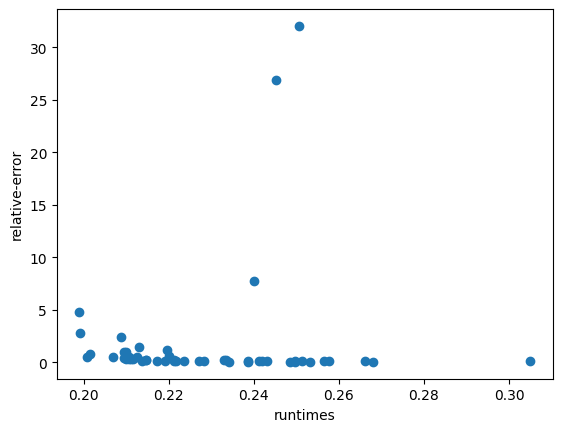

In [ ]:
fb_graph = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
mq = 50
errors = np.zeros(mq)
runtimes = np.zeros(mq)
exact_count = exact_netx(fb_graph)['triangles']
for num_queries in range(mq):
    rel_error = runtime = 0
    for i in range(10):
        outcome = hutchplusplus(fb_graph, (num_queries+1)*3)
        rel_error += np.abs((outcome['triangles'] - exact_count)/exact_count)
        runtime += outcome['time']
    errors[num_queries] = rel_error/10
    runtimes[num_queries] = runtime/10
print(runtimes)
print(errors)
plt.scatter(runtimes, errors*100)
plt.xlabel('runtimes')
plt.ylabel('relative-error')

1.922923152268316


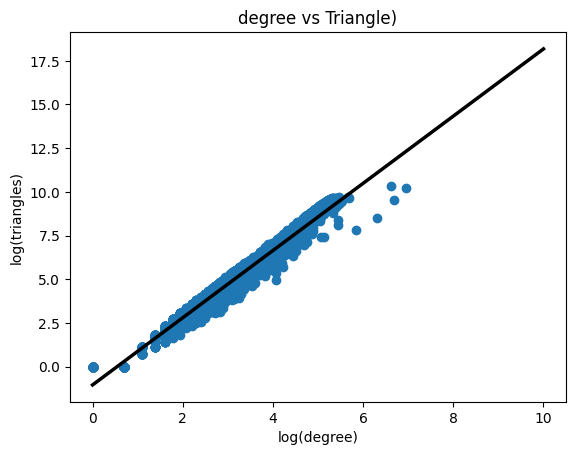

In [ ]:
fb_graph = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
degrees=[]
triangles=[]
for node in fb_graph:
  degree=fb_graph.degree(node)
  degree=0 if degree<=1 else math.log(degree)
  triangle=nx.triangles(fb_graph,node)
  triangle=0 if triangle<=1 else math.log(triangle)
  degrees.append(degree)
  triangles.append(triangle)

degrees=np.array(degrees)
triangles=np.array(triangles)
plt.scatter(degrees,triangles)
plt.xlabel('log(degree)')
plt.ylabel('log(triangles)')
plt.title('degree vs Triangle)')
b, a = np.polyfit(degrees, triangles, deg=1)
print(b)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 10, num=80)

# Plot regression line
plt.plot(xseq, a + b * xseq, color="k", lw=2.5)
plt.show()